In [1]:
### Set up directory
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Check if directory exists, if not create it
save_path = os.path.join(parent_dir, 'generated_series')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
import pickle
from scipy.integrate import odeint


def serialize_gaussian(prec, time_series, mean_series, sigma_series):
    """
    Serialize a time series with gaussian noise and continuous support.

    Parameters:
    prec (int): Precision of the serialization
    time_series (list): The time series data
    mean_series (list): The mean series data
    sigma_series (list): The sigma series data

    Returns:
    tuple: A tuple containing 
        serialized time series: str
        rescaled mean series: np array
        rescaled sigma series: np array
    """
    settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
    time_series = np.array(time_series)
    ### Final range is from 0.15 to 0.85
    rescale_factor = 0.7
    up_shift = 0.15

    rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_sigma_arr = np.array(sigma_series)/(time_series.max()-time_series.min()) * rescale_factor 
    rescaled_true_mean_arr *= 10
    rescaled_true_sigma_arr *= 10
    full_series = serialize_arr(rescaled_array, settings)
    return (full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr)

def generate_transition_matrix(N_state):
    """
    Generate a random transition matrix of shape (N_state, N_state).
    Each row sums to 1.
    """
    P = np.random.rand(N_state, N_state)
    P /= P.sum(axis=1)[:, np.newaxis]
    return P

def generate_gaussian_matrix(N_state, sigma = 0.5):
    """
    Generate a transition matrix of shape (N_state, N_state) for an uncorrelated Brownian motion.
    Each row will be the same, representing discretized bins of a Gaussian distribution.
    The sum of each row is normalized to 1.

    :param N_state: Number of states (and thus size of the transition matrix)
    :param sigma: Standard deviation of the Gaussian distribution (controls the width of the Gaussian)
    """
    # Define the bins for the Gaussian distribution
    bins = np.linspace(-3, 3, N_state)
    
    # Calculate the Gaussian distribution values for these bins
    gaussian_distribution = np.exp(-0.5 * (bins / sigma) ** 2)
    gaussian_distribution /= gaussian_distribution.sum()  # Normalize to sum to 1

    # Repeat this distribution for each row to create the transition matrix
    P = np.tile(gaussian_distribution, (N_state, 1))

    return P

### Generate Series with Continuous Support

In [2]:
num_series = 1
llama_size = '13b'
# mode = 'neighbor'
# prec = 3
# refine_depth = 2
# mode = 'all'
# prec = 2
# refine_depth = 0
mode = 'neighbor'
prec = 3
refine_depth = 1

In [4]:
####################################
### Generate continuous time series
####################################

### Brownian Motion



traj_name = 'brownian_motion'
Nt = 1000 # number of steps
a = 0 # drift

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

for traj_idx in range(num_series):
    random_seed = 7+traj_idx
    print("random_seed: ", random_seed)
    np.random.seed(random_seed)
    # Initialize the time series
    x = 0  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt
        x_sigma = sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, alpha = 1)

    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': refine_depth,
        'random_seed': random_seed,
        'time_series': np.array(time_series)
    }

    # Pickle and save the dictionary
    # Count existing files in the save_path and assign a new number
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)


random_seed:  7


random_seed:  0


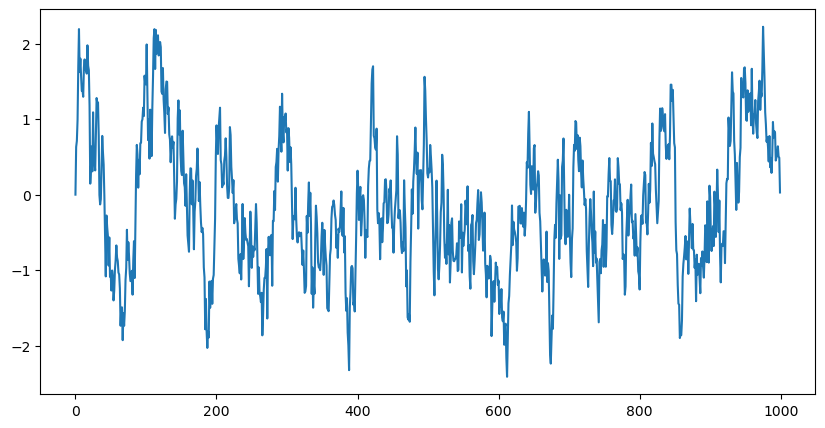

In [5]:


traj_name = 'correlated_gaussian'
Nt = 1000 # number of steps
a = 0 # drift
theta = 0.5 # restoring spring constant

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

for traj_idx in range(num_series):
    random_seed = traj_idx
    print("random_seed: ", random_seed)
    np.random.seed(random_seed)
    # Initialize the time series
    x = 0  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt - x * theta*dt
        x_sigma = sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
        
    plt.figure(figsize=(10, 5))
    plt.plot(time_series, alpha = 1)

    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': refine_depth,
        'random_seed': random_seed,
        'time_series': np.array(time_series)
    }

    # Pickle and save the dictionary
    # Count existing files in the save_path and assign a new number
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)


In [6]:
### Gemetric Brownian Motion
traj_name = 'geometric_brownian_motion'
# hyper-parameter to load from json


Nt = 1000 # number of steps
sigma = 0.6
a = None

if a is None:
    a = sigma**2/2
    
dt =  0.2 # time step
tspan = np.linspace(1, Nt*dt, Nt)

for traj_idx in range(num_series):
    random_seed = traj_idx+2
    np.random.seed(random_seed)

    # Initialize the time series
    x = 10  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt
        x_sigma = x * sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, alpha = 1)
    # plt.yscale('log')
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
        # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }

    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)



good seed: 3


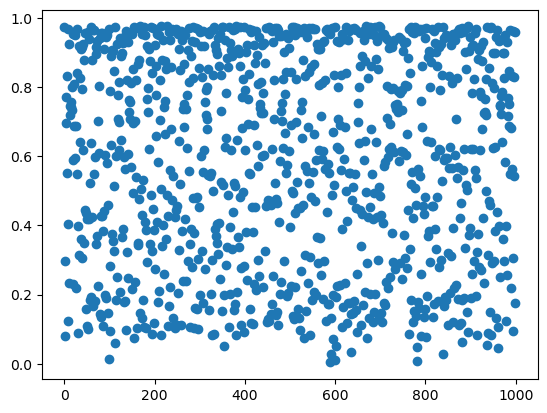

In [7]:
### Noisy Logistic Map
traj_name = 'noisy_logistic_map'
# hyper-parameter to load from json


Nt = 1000
sigma = 0.0136
r = 3.9

### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

counter = -1
traj_idx = 3
while counter < num_series-1:
    random_seed = traj_idx
    np.random.seed(random_seed)
    traj_idx += 1
    x = 0.5 
    x_diff = 0 # Initial uncertainty is zero
    time_series = []
    mean_series = []
    sigma_series = []
        
    for i in range(Nt):
        x_mean = logistic_map(r, x)
        x_sigma = x_diff * sigma
        x = logistic_map(r, x + sigma * np.random.normal())
        x_diff = logistic_map_diff(r, x)
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
    
    if np.any(np.abs(np.array(time_series))>1):
        # discard stray trajectories
        continue
    else:
        print(f"good seed: {traj_idx-1}")
        counter += 1
        
    plt.plot(time_series, alpha = 1, lw = 0, marker = 'o')
    plt.show()
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

good seed: 0


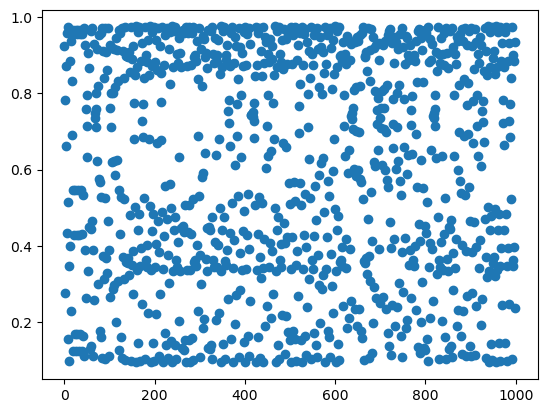

good seed: 1


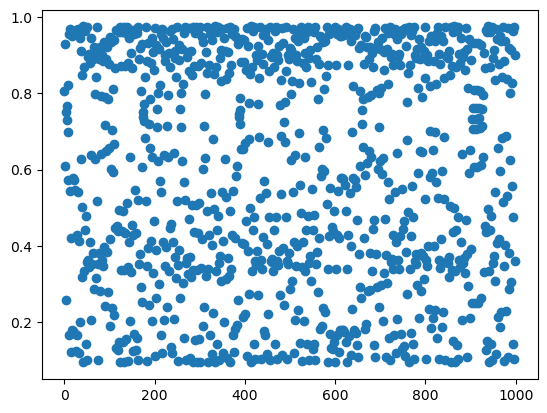

good seed: 2


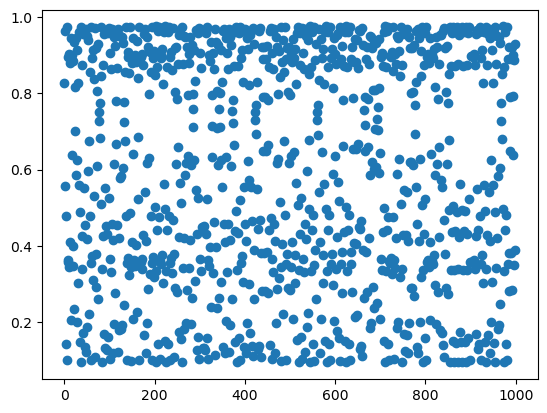

good seed: 3


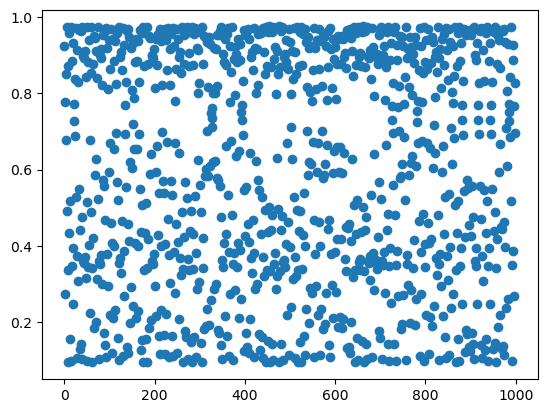

good seed: 4


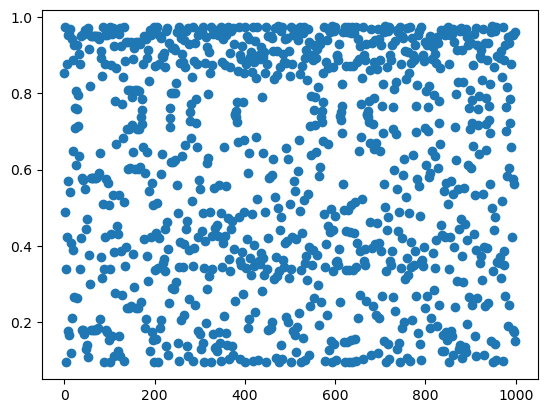

good seed: 5


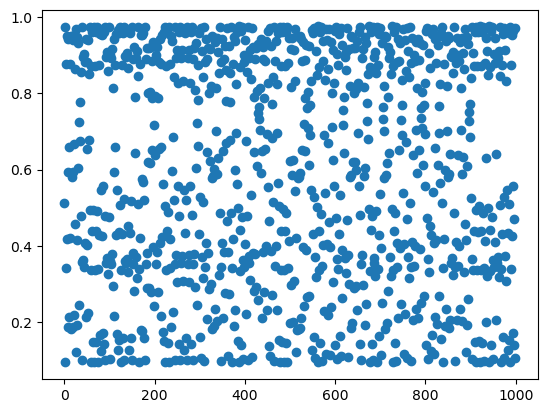

good seed: 6


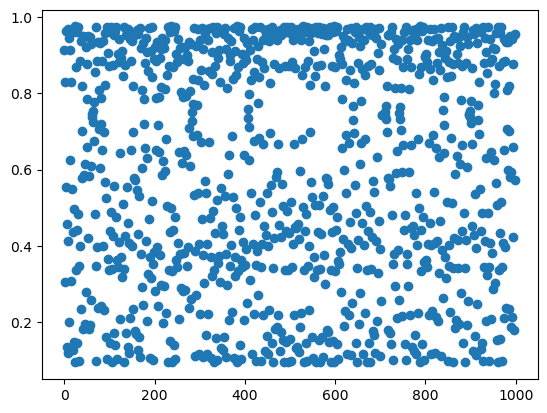

good seed: 7


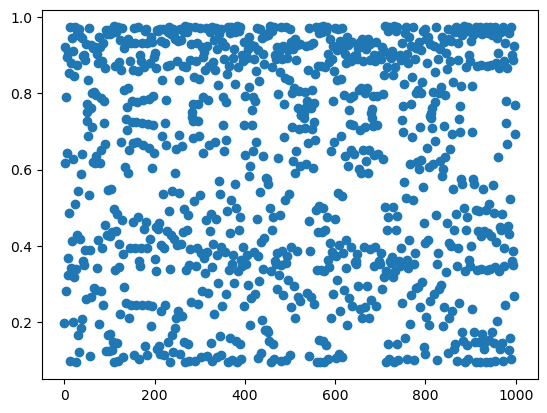

good seed: 8


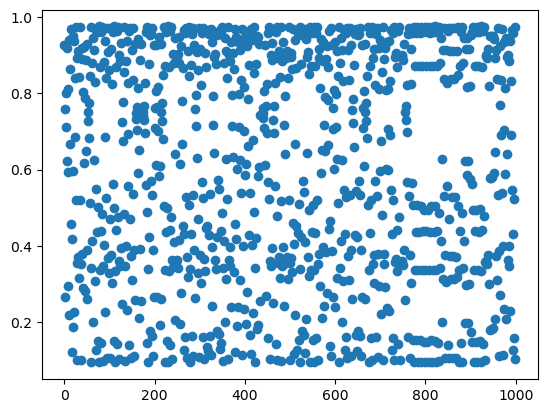

good seed: 9


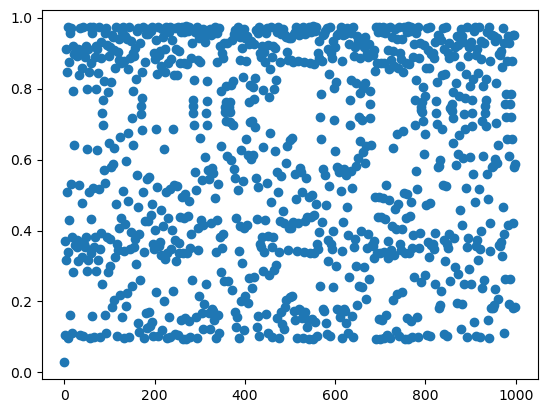

In [3]:
### Logistic Map
traj_name = 'logistic_map'
# hyper-parameter to load from json

Nt = 1000
sigma = 0
r = 3.9

### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

counter = -1
traj_idx = 0
while counter < num_series-1:
    random_seed = traj_idx
    np.random.seed(random_seed)
    traj_idx += 1
    x = np.random.uniform() * 0.7
    x_diff = 0 # Initial uncertainty is zero
    time_series = []
    mean_series = []
    sigma_series = []
        
    for i in range(Nt):
        x_mean = logistic_map(r, x)
        x_sigma = x_diff * sigma
        x = logistic_map(r, x + sigma * np.random.normal())
        x_diff = logistic_map_diff(r, x)
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
    
    if np.any(np.abs(np.array(time_series))>1):
        # discard stray trajectories
        continue
    else:
        print(f"good seed: {traj_idx-1}")
        counter += 1
        
    plt.plot(time_series, alpha = 1, lw = 0, marker = 'o')
    plt.show()
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

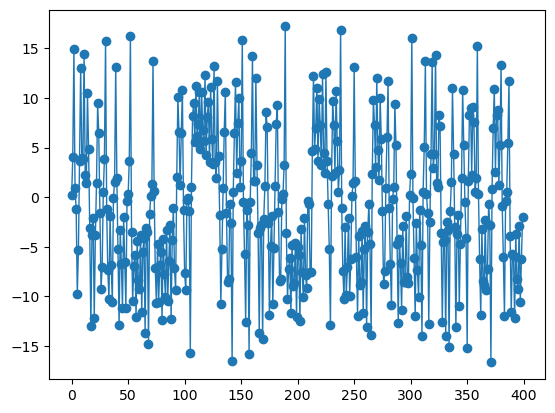

In [16]:
traj_name = 'lorenz_system'
# hyper-parameter to load from json

# Nt = 1000
# Nt = 300
Nt = 400
tspan = np.linspace(0, 100, Nt)
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(state, t):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

counter = -1
traj_idx = 0
for i in range(num_series):
    # Specific initial condition
    
    random_seed = i
    np.random.seed(random_seed)
    initial_state = [np.random.uniform()*0.3, 2.01, 23.02] 
    
    solution = odeint(lorenz, initial_state, tspan)
    X = solution[:, 0]
    time_series = X.tolist()
    mean_series = time_series
    sigma_series = [0] * Nt
    
        
    plt.plot(time_series, alpha = 1, lw = 1, marker = 'o')
    plt.show()
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

In [1]:
traj_name = 'rint_system'
# hyper-parameter to load from json

# Nt = 1000
# Nt = 300
Nt = 400
tspan = np.linspace(0, 100, Nt)
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

tau = 10.0
rp = 1.0
r0=1
q = 1.0


def batterie_soc(current, t):
    dxdt = -current(t) /q
    return [dxdt]

"""
def rint(state, t):
    u, i, s = state
    dudt = (1/tau) * (rp*i - u)
    didt = 0
    dsdt = -i/q
    return [dudt, didt, dsdt]
"""

counter = -1
traj_idx = 0
for i in range(num_series):
    # Specific initial condition
    
    random_seed = i
    np.random.seed(random_seed)
    initial_state = [np.random.uniform()*0.3, 2.01, 23.02] 
    
    solution = odeint(rint, initial_state, tspan)
    X = solution[:, 0]
    time_series = X.tolist()
    mean_series = time_series
    sigma_series = [0] * Nt
    
        
    plt.plot(time_series, alpha = 1, lw = 1, marker = 'o')
    plt.show()
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

NameError: name 'np' is not defined

In [3]:
### Uncorrelated Gaussian
traj_name = 'uncorrelated_gaussian'


Nt = 1000 
sigma = 1
for traj_idx in range(num_series):
    random_seed = traj_idx+2
    np.random.seed(random_seed)
    time_series = []
    mean_series = []
    sigma_series = []
    for t in range(0, Nt):
        W =  np.random.normal() * sigma 
        
        time_series.append(W)
        mean_series.append(0)
        sigma_series.append(sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

In [86]:
### Uncorrelated Uniform
traj_name  = 'uncorrelated_uniform'
# hyper-parameter to load from json



Nt = 1000 


sigma = 1
for traj_idx in range(num_series):
    random_seed = traj_idx
    np.random.seed(random_seed)
    time_series = []
    mean_series = []
    sigma_series = []
    for t in range(0, Nt):
        W =  np.random.uniform() * sigma 
        
        time_series.append(W)
        # mean_series.append(0)
        # sigma_series.append(sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth,
            'random_seed': random_seed,
            'time_series': np.array(time_series)
        }
    
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

### Generate Markov Chains

In [10]:
time_sep = ""

In [11]:
llama_size_list = ['13b','13b','13b','13b','13b','13b']
Nt_list = [1500, 1500, 1500, 1500, 1500, 1500, 1500]
N_state_list = [4,5,6,7,8,9,10]
random_seed_list = [1,1,1,1,1,1,1]

llama_size_list += ['70b','70b','70b']
Nt_list += [1500, 1500, 1500]
N_state_list += [8,9,10]
random_seed_list += [1,1,1]

In [10]:
llama_size_list = ['13b','13b','13b','13b','13b','13b','13b','13b','13b']
Nt_list = [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
N_state_list = [4] * 9
random_seed_list = [2,3,4,5,6,7,8,9,10]

In [11]:
traj_name  = 'markov_chain'
for llama_size, Nt, N_state, random_seed in zip(llama_size_list, Nt_list, 
                                                N_state_list, random_seed_list):
    states = np.arange(N_state)
    chain = [0]
    np.random.seed(random_seed)
    P = generate_transition_matrix(N_state)
        
    for t in range(1, Nt):
        current_state = chain[-1]
        next_state = np.random.choice(states, p=P[current_state])
        chain.append(next_state)
    
    # Convert the chain list to a string and store it in full_series
    full_series = "".join(str(x) for x in chain)
    
    data_dict = {
            'full_series': full_series,
            'full_array': np.array(chain),
            'llama_size': llama_size,
            
            'random_seed': random_seed,
            'P': P
        }
    # Pickle and save the dictionary
    file_indices = [int(name[:-4].rsplit('_',1)[1]) for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)]
    file_indices += [-1]
    save_name = os.path.join(save_path, f'{traj_name}_{max(file_indices)+1}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

### Generate Deterministic Series